In [2]:
#dataset preparation
import pandas as pd

csv_file = 'CPRM_AutoLOan_OnlineAutoLoanData.csv'
df = pd.read_csv(csv_file)
def CalculatePD(a):
    if(a == 1):
        return 0.01
    if(a == 2):
        return 0.01
    if(a == 3):
        return 0.044
    if(a == 4):
        return 0.089
    if(a == 5):
        return 0.158
    if(a == 6):
        return 0.225
    if(a == 7):
        return 0.284
    if(a >= 8):
        return 0.41
    return 1

def total_value_of_loan(principal, annual_rate, months):
    monthly_rate = annual_rate / 12.0
    if monthly_rate < 0:
        return principal

    total_value = principal + principal * monthly_rate * months
    return total_value
def CalculateReward(accept,PD,amount,term,rate,prime_rate):
    TotalPayment = total_value_of_loan(amount,rate / 100,term)
    CapitalCost = total_value_of_loan(amount,prime_rate / 100,term)
    reward = accept * ((1-PD)*(TotalPayment - CapitalCost) - PD * 0.5 * CapitalCost)
    return reward


In [3]:

def convert_row_to_dict(row, next_state_values,done):
    state_columns = ["Term","Amount_Approved","Primary_FICO","Competition_rate","onemonth","Tier","partnerbin","months","CarType_id"]
    state_values = [row[col] for col in state_columns]
    PD = CalculatePD(row["Tier"])
    state_values.append(PD)
    r = CalculateReward(row["apply"],PD,row["Amount_Approved"],row["Term"],row["rate"],row["onemonth"])
    return {
        'state': state_values,
        'action': row['rate'],
        'reward': float(r),
        'next_state': next_state_values,
        'done': done
    }

formatted_dataset = []
for idx, row in enumerate(df.iterrows()):
    _, row_data = row
    if idx < len(df) - 1:
        next_row_data = df.iloc[idx + 1]
        next_state_columns = ["Term","Amount_Approved","Primary_FICO","Competition_rate","onemonth","Tier","partnerbin","months","CarType_id"]
        PD = CalculatePD(next_row_data["Tier"])
        next_state_values = [next_row_data[col] for col in next_state_columns]
        next_state_values.append(PD)
    else:
        next_state_values = [row_data[col] for col in next_state_columns]  # or set it to a default value
        next_state_values.append(0.1)
    if(idx < len(df) - 1):
        done = 0
    else:
        done = 1
    formatted_dataset.append(convert_row_to_dict(row_data, next_state_values,done))


In [180]:
print(list(df['Amount_Approved']).index(100000))
print(list(df['Amount_Approved'])[128353])

112761
45000.0


In [4]:
#Complete the dataset: divided episodes
from d3rlpy.dataset import MDPDataset
import numpy as np
states = []
actions = []
rewards = []
next_states = []
dones = []

for data in formatted_dataset:
    states.append(data['state'])
    actions.append([data['action']])
    rewards.append(data['reward'])
    next_states.append(data['next_state'])
    dones.append(data['done'])
states = np.array(states)
actions = np.array(actions)
rewards = np.array(rewards)
next_states = np.array(next_states,dtype=np.float64)
dones = np.array(dones)
episode_terminals = np.random.randint(2, size=208085)
dataset = MDPDataset(
    observations=states,
    actions=actions,
    rewards=rewards,
    terminals=dones,
    episode_terminals=episode_terminals
)

In [185]:
from d3rlpy.algos import CQL
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2)
cql = CQL(use_gpu=True)
cql.build_with_dataset(dataset)
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer

# calculate metrics with test dataset
td_error = td_error_scorer(cql, test_data)
cql.fit(train_data,
        eval_episodes=test_data,
        n_epochs=10,
        scorers={
            'td_error': td_error_scorer,
            'value_scale': average_value_estimation_scorer,
        })

KeyboardInterrupt: 

In [42]:
# train the CQL model
from d3rlpy.algos import CQL
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import td_error_scorer
from sklearn.model_selection import train_test_split
from d3rlpy.preprocessing import MinMaxActionScaler
train_data, test_data = train_test_split(dataset, test_size=0.2)
action_scaler = MinMaxActionScaler(dataset,minimum=0, maximum=10)  # Set the min and max values according to your problem
cql = CQL(
    batch_size=100,
    n_epochs=20,
    scaler='standard',  # or 'standard' or any other scaler you prefer
    action_scaler='min_max',
    q_func_factory='qr',
    use_gpu=1,  # set to False if you don't have a GPU
)
cql.fit(
    train_data,
    eval_episodes=test_data,  # to evaluate the algorithm during training
    n_epochs=20,
    scorers={
        'td_error': td_error_scorer,
    },
    with_timestamp=True,
    verbose=True,
)
cql.save_model('cql_trained_model.pth2')

2023-03-16 05:46:00 [warning  ] Unused arguments are passed.   n_epochs=20
2023-03-16 05:46:00 [debug    ] RoundIterator is selected.
2023-03-16 05:46:00 [info     ] Directory is created at d3rlpy_logs/CQL_20230316054600
2023-03-16 05:46:00 [debug    ] Fitting scaler...              scaler=standard
2023-03-16 05:46:00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 05:46:00 [debug    ] Building models...
2023-03-16 05:46:00 [debug    ] Models have been built.
2023-03-16 05:46:00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316054600/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([[2.45]], dtype=float32), 'maximum': array([[11.55]], dtype=float32)}}, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsg

Epoch 1/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:47:27 [info     ] CQL_20230316054600: epoch=1 step=835 epoch=1 metrics={'time_sample_batch': 0.0004052993066296606, 'time_algorithm_update': 0.054723795588145, 'temp_loss': 0.3057322310937658, 'temp': 0.9861469757057235, 'alpha_loss': -24.44963085151718, 'alpha': 1.0541097266945296, 'critic_loss': 23321.700454949478, 'actor_loss': -346.9367227430115, 'time_step': 0.05531702384263455, 'td_error': 3754423.49762865} step=835
2023-03-16 05:47:27 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_835.pt


Epoch 2/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:48:54 [info     ] CQL_20230316054600: epoch=2 step=1670 epoch=2 metrics={'time_sample_batch': 0.00041519667574031624, 'time_algorithm_update': 0.05463409452381248, 'temp_loss': 0.3049977442903969, 'temp': 0.9690528391364092, 'alpha_loss': -22.160597868593868, 'alpha': 1.1465154210964363, 'critic_loss': 38580.33899700599, 'actor_loss': -1972.037678354229, 'time_step': 0.05524325570660437, 'td_error': 3890139.6049112366} step=1670
2023-03-16 05:48:54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_1670.pt


Epoch 3/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:50:22 [info     ] CQL_20230316054600: epoch=3 step=2505 epoch=3 metrics={'time_sample_batch': 0.0004191689862462575, 'time_algorithm_update': 0.05502036203167396, 'temp_loss': 0.7128231581635104, 'temp': 0.8907233909218611, 'alpha_loss': -13.077799053534775, 'alpha': 1.220592958912878, 'critic_loss': 59824.976314558386, 'actor_loss': -4119.660010642777, 'time_step': 0.05563327195401677, 'td_error': 3888240.561317108} step=2505
2023-03-16 05:50:22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_2505.pt


Epoch 4/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:51:50 [info     ] CQL_20230316054600: epoch=4 step=3340 epoch=4 metrics={'time_sample_batch': 0.0004045689177370357, 'time_algorithm_update': 0.05495649583325415, 'temp_loss': 0.5041648163766919, 'temp': 0.8185266997285946, 'alpha_loss': -9.538958042396043, 'alpha': 1.2846806770313286, 'critic_loss': 78421.64386227545, 'actor_loss': -6436.256157021894, 'time_step': 0.05555517716322116, 'td_error': 3867326.188977769} step=3340
2023-03-16 05:51:50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_3340.pt


Epoch 5/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:53:17 [info     ] CQL_20230316054600: epoch=5 step=4175 epoch=5 metrics={'time_sample_batch': 0.00041767251705695054, 'time_algorithm_update': 0.05503304018945751, 'temp_loss': 0.2714403063995752, 'temp': 0.7733812403536129, 'alpha_loss': -8.135070948115366, 'alpha': 1.3562202876199505, 'critic_loss': 94158.50036489521, 'actor_loss': -8739.308273297156, 'time_step': 0.055648365991558146, 'td_error': 3823105.63656164} step=4175
2023-03-16 05:53:17 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_4175.pt


Epoch 6/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:54:45 [info     ] CQL_20230316054600: epoch=6 step=5010 epoch=6 metrics={'time_sample_batch': 0.00041246214312707594, 'time_algorithm_update': 0.055295223247505236, 'temp_loss': 0.11965479019987132, 'temp': 0.745810913968229, 'alpha_loss': -7.585432867518442, 'alpha': 1.4408925349127033, 'critic_loss': 107471.7264782934, 'actor_loss': -10963.18519367515, 'time_step': 0.055901104533029884, 'td_error': 3790644.511034205} step=5010
2023-03-16 05:54:45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_5010.pt


Epoch 7/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:56:14 [info     ] CQL_20230316054600: epoch=7 step=5845 epoch=7 metrics={'time_sample_batch': 0.00042286119061315847, 'time_algorithm_update': 0.05586401088509017, 'temp_loss': 0.058295980556296395, 'temp': 0.7290165311562087, 'alpha_loss': -7.682249953218563, 'alpha': 1.544392601601378, 'critic_loss': 119103.3255239521, 'actor_loss': -13119.394117234282, 'time_step': 0.056482795612540784, 'td_error': 3747896.0686291447} step=5845
2023-03-16 05:56:14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_5845.pt


Epoch 8/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:57:42 [info     ] CQL_20230316054600: epoch=8 step=6680 epoch=8 metrics={'time_sample_batch': 0.00041780300483018336, 'time_algorithm_update': 0.05510665756499696, 'temp_loss': 0.04104323384910709, 'temp': 0.7151438272641805, 'alpha_loss': -7.966116029202581, 'alpha': 1.669036758445694, 'critic_loss': 129475.71149887725, 'actor_loss': -15182.891653022081, 'time_step': 0.0557201773820523, 'td_error': 3730895.1268248796} step=6680
2023-03-16 05:57:42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_6680.pt


Epoch 9/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 05:59:09 [info     ] CQL_20230316054600: epoch=9 step=7515 epoch=9 metrics={'time_sample_batch': 0.000424585513725966, 'time_algorithm_update': 0.055158045191964704, 'temp_loss': 0.028664178714141512, 'temp': 0.7015420665284117, 'alpha_loss': -8.300976381473198, 'alpha': 1.8130805900710785, 'critic_loss': 138679.35410741018, 'actor_loss': -17160.135881362276, 'time_step': 0.05577835494172787, 'td_error': 3689407.987507016} step=7515
2023-03-16 05:59:09 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_7515.pt


Epoch 10/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:00:36 [info     ] CQL_20230316054600: epoch=10 step=8350 epoch=10 metrics={'time_sample_batch': 0.00040840588643879235, 'time_algorithm_update': 0.05456738671856726, 'temp_loss': 0.023323182939394227, 'temp': 0.689854533372525, 'alpha_loss': -8.713387392238229, 'alpha': 1.973124210420483, 'critic_loss': 147010.77363398203, 'actor_loss': -19038.718579247754, 'time_step': 0.055165861038390746, 'td_error': 3643681.772787117} step=8350
2023-03-16 06:00:36 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_8350.pt


Epoch 11/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:02:03 [info     ] CQL_20230316054600: epoch=11 step=9185 epoch=11 metrics={'time_sample_batch': 0.0003918596370491439, 'time_algorithm_update': 0.05434816012125529, 'temp_loss': 0.022222124073308654, 'temp': 0.6746321702431776, 'alpha_loss': -9.279785704469967, 'alpha': 2.15290968460951, 'critic_loss': 154901.2525261976, 'actor_loss': -20860.31497941617, 'time_step': 0.05493024751811684, 'td_error': 3602420.792283945} step=9185
2023-03-16 06:02:03 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_9185.pt


Epoch 12/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:03:31 [info     ] CQL_20230316054600: epoch=12 step=10020 epoch=12 metrics={'time_sample_batch': 0.0004017070381941196, 'time_algorithm_update': 0.054979640994957106, 'temp_loss': 0.03347755330542204, 'temp': 0.6548445516717648, 'alpha_loss': -9.87504311293185, 'alpha': 2.3505961101212187, 'critic_loss': 162133.83293413173, 'actor_loss': -22582.75762069611, 'time_step': 0.055580829289145095, 'td_error': 3560669.8108848585} step=10020
2023-03-16 06:03:31 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_10020.pt


Epoch 13/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:04:58 [info     ] CQL_20230316054600: epoch=13 step=10855 epoch=13 metrics={'time_sample_batch': 0.0004065402253659186, 'time_algorithm_update': 0.05541385462184152, 'temp_loss': 0.03689274464563633, 'temp': 0.6300793539264244, 'alpha_loss': -10.583662942212499, 'alpha': 2.5685507685838345, 'critic_loss': 168828.02501871256, 'actor_loss': -24228.318834206588, 'time_step': 0.05601350818565506, 'td_error': 3539291.0081066135} step=10855
2023-03-16 06:04:58 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_10855.pt


Epoch 14/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:06:25 [info     ] CQL_20230316054600: epoch=14 step=11690 epoch=14 metrics={'time_sample_batch': 0.00041616919511806464, 'time_algorithm_update': 0.05486435490454029, 'temp_loss': 0.030751835445794667, 'temp': 0.6045489753791672, 'alpha_loss': -11.300023699092295, 'alpha': 2.8070171678851463, 'critic_loss': 175262.93680763472, 'actor_loss': -25814.85943581587, 'time_step': 0.05547449802924059, 'td_error': 3542352.385052828} step=11690
2023-03-16 06:06:25 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_11690.pt


Epoch 15/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:07:53 [info     ] CQL_20230316054600: epoch=15 step=12525 epoch=15 metrics={'time_sample_batch': 0.0004050597459256292, 'time_algorithm_update': 0.05532550554789469, 'temp_loss': 0.02906618773606801, 'temp': 0.5835790209427565, 'alpha_loss': -12.121127732785162, 'alpha': 3.0688973912221944, 'critic_loss': 181150.56446482035, 'actor_loss': -27302.321390812125, 'time_step': 0.0559238762198808, 'td_error': 3495948.8654960264} step=12525
2023-03-16 06:07:53 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_12525.pt


Epoch 16/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:09:22 [info     ] CQL_20230316054600: epoch=16 step=13360 epoch=16 metrics={'time_sample_batch': 0.00042338885233073894, 'time_algorithm_update': 0.05540196567238448, 'temp_loss': 0.01890384660988264, 'temp': 0.5669260723862105, 'alpha_loss': -13.034675657535027, 'alpha': 3.355406248069809, 'critic_loss': 186897.29764221556, 'actor_loss': -28740.574309973803, 'time_step': 0.056023479507354916, 'td_error': 3455950.551747131} step=13360
2023-03-16 06:09:22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_13360.pt


Epoch 17/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:10:49 [info     ] CQL_20230316054600: epoch=17 step=14195 epoch=17 metrics={'time_sample_batch': 0.0004244276149544173, 'time_algorithm_update': 0.05527049652830569, 'temp_loss': 0.00907070553310154, 'temp': 0.5576257304517095, 'alpha_loss': -14.050283460559958, 'alpha': 3.669432202070773, 'critic_loss': 192393.1272267964, 'actor_loss': -30113.85947558009, 'time_step': 0.055889690993074885, 'td_error': 3504117.8503296804} step=14195
2023-03-16 06:10:49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_14195.pt


Epoch 18/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:12:16 [info     ] CQL_20230316054600: epoch=18 step=15030 epoch=18 metrics={'time_sample_batch': 0.00041177658263794677, 'time_algorithm_update': 0.05518346232568432, 'temp_loss': 0.011109448883215956, 'temp': 0.5509407585966373, 'alpha_loss': -15.23171079487144, 'alpha': 4.01443788534153, 'critic_loss': 197620.34470434132, 'actor_loss': -31415.152678237275, 'time_step': 0.05578710618847144, 'td_error': 3452864.3090146524} step=15030
2023-03-16 06:12:16 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_15030.pt


Epoch 19/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:13:42 [info     ] CQL_20230316054600: epoch=19 step=15865 epoch=19 metrics={'time_sample_batch': 0.00039047081313447324, 'time_algorithm_update': 0.05426464080810547, 'temp_loss': 0.00559246290574815, 'temp': 0.5443728559031458, 'alpha_loss': -16.506815647650622, 'alpha': 4.393278415474349, 'critic_loss': 202731.0269461078, 'actor_loss': -32667.09454528443, 'time_step': 0.05484421410246523, 'td_error': 3412951.1916040923} step=15865
2023-03-16 06:13:43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_15865.pt


Epoch 20/20:   0%|          | 0/835 [00:00<?, ?it/s]

2023-03-16 06:15:09 [info     ] CQL_20230316054600: epoch=20 step=16700 epoch=20 metrics={'time_sample_batch': 0.0003850197363756374, 'time_algorithm_update': 0.054327829155379426, 'temp_loss': 0.0038201787474430667, 'temp': 0.5388043320821431, 'alpha_loss': -17.938791168806794, 'alpha': 4.808944747262372, 'critic_loss': 207609.74801646706, 'actor_loss': -33858.14364941991, 'time_step': 0.054897843720670234, 'td_error': 3423880.838509511} step=16700
2023-03-16 06:15:09 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316054600/model_16700.pt


In [5]:
#Create logistic regression dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def convert_row_to_dict1(row):
    state_columns = ["Term","Amount_Approved","Primary_FICO","Competition_rate","onemonth","Tier","partnerbin","months","CarType_id","rate"]
    state_values = [row[col] for col in state_columns]
    PD = CalculatePD(row["Tier"])
    state_values.append(PD)
    return {
        'X': state_values,
        'y': row['apply'],
    }
csv_file1 = 'CPRM_AutoLOan_OnlineAutoLoanData.csv'
df1 = pd.read_csv(csv_file1)
formatted_dataset1 = []
for idx, row in enumerate(df1.iterrows()):
    _, row_data = row
    formatted_dataset1.append(convert_row_to_dict1(row_data))

In [6]:
# continue constructing logistic dataset
X = []
y = []
import numpy as np
for data in formatted_dataset1:
    X.append(data['X'])
    y.append([data['y']])
X = np.array(X)
y = np.array(y)
y = y.reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
#train logistic model
logistic_regression = LogisticRegression(max_iter = 1000000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

In [ ]:
#test logistic model
y_pred = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(np.shape(X_test))
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [12]:
#load cql
from d3rlpy.algos import CQL
cql = CQL()
cql.build_with_dataset(dataset)
cql.load_model('cql_trained_model.pth2')

FileNotFoundError: [Errno 2] No such file or directory: 'cql.trained_model.pth2'

In [44]:
# test on the simulated dataset
from datetime import datetime
trained_cql = {}
logistic = {}
def convert_row_to_dict2(row):
    state_columns = ["Term","Amount_Approved","Primary_FICO","Competition_rate","onemonth","Tier","partnerbin","months","CarType_id","rate"]
    state_values = [row[col] for col in state_columns]
    PD = CalculatePD(row["Tier"])
    state_values.append(PD)
    return {
        'states': state_values,
        'date':row["Approve_Date"]
    }
csv_file2 = 'CPRM_AutoLOan_OnlineAutoLoanData.csv'
df2 = pd.read_csv(csv_file2)
for idx, row in enumerate(df2.iterrows()):
    if(idx < 14000):
        _, row_data = row
        A1 = convert_row_to_dict2(row_data)
        X1 = A1['states']
        X1 = np.array(X1).reshape(1,-1)
        X2 = np.array(X1).reshape(1,-1)
        date1 = A1['date']
        date1 = datetime.strptime(date1, '%m/%d/%Y')
        if date1 in logistic:
            logistic[date1] += CalculateReward(logistic_regression.predict(X1),X1[0][-1],X1[0][1],X1[0][0],X1[0][-2],X1[0][4])
        else:
            logistic[date1] = CalculateReward(logistic_regression.predict(X1),X1[0][-1],X1[0][1],X1[0][0],X1[0][-2],X1[0][4])
        X2[0][-2] = cql.predict(np.delete(X1, X1.shape[1] - 2, axis=1))
        print(X2[0][-2])
        if date1 in trained_cql:
            trained_cql[date1] += CalculateReward(logistic_regression.predict(X2),X2[0][-1],X2[0][1],X2[0][0],X2[0][-2],X2[0][4])
        else:
            trained_cql[date1] = CalculateReward(logistic_regression.predict(X2),X2[0][-1],X2[0][1],X2[0][0],X2[0][-2],X2[0][4])
    


6.677262306213379
5.250528335571289
5.289356708526611
8.655440330505371
5.338372230529785
5.052105903625488
5.96068811416626
5.6380720138549805
8.522353172302246
5.614992141723633
8.13838005065918
5.766546249389648
5.347836494445801
5.474760055541992
6.661089897155762
5.841973304748535
5.670455455780029
5.277749061584473
5.61736536026001
6.2405500411987305
6.1406636238098145
6.253050804138184
5.898074150085449
6.7108154296875
5.637350559234619
5.289158821105957
5.553001403808594
4.641684055328369
8.238455772399902
5.844506740570068
6.671462059020996
5.776463985443115
5.38884162902832
6.0817413330078125
6.276679039001465
5.972823143005371
5.190674304962158
5.526181221008301
6.1688551902771
5.687117576599121
5.718398094177246
4.995715141296387
5.367321968078613
5.669053077697754
5.599109649658203
5.227062225341797
6.631901741027832
8.704477310180664
5.291130065917969
6.051509857177734
4.936163902282715
5.152881622314453
5.150981903076172
6.169698715209961
6.129274368286133
5.382182121276

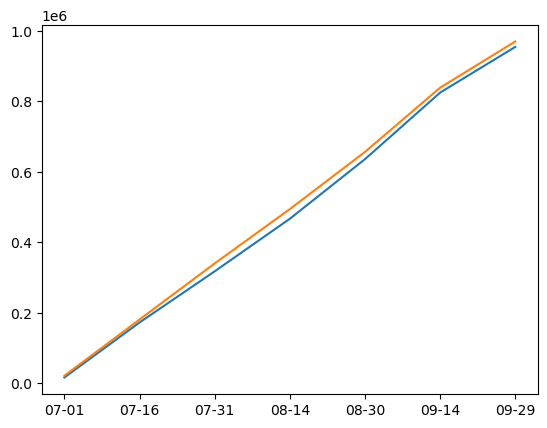

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
a = list(logistic.keys())
b = list(logistic.values())
c = list(trained_cql.values())
dates = []
for date in a:
    dates.append(date.strftime("%m-%d"))
cum_values = np.cumsum(list(logistic.values()), axis = 0)
plt.plot(cum_values[::15])
cum_values1 = np.cumsum(list(trained_cql.values()), axis = 0)
plt.plot(cum_values1[::15])
plt.xticks(ticks = np.linspace(start = 0, stop = len(cum_values[::15]) - 1, num = len(cum_values[::15])), labels = dates[::15])
plt.show()

In [ ]:
dates = []
for date in a:
    dates.append(date.strftime("%m-%d"))

In [ ]:
plt.plot(cum_values[::15])
plt.xticks(ticks = np.linspace(start = 0, stop = len(cum_values[::15]) - 1, num = len(cum_values[::15])), labels = dates[::15])
plt.show()

In [ ]:
dates[::15]

In [ ]:
cum_values = np.cumsum(list(logistic.values()), axis = 0)
plt.plot(cum_values[::15])

In [ ]:
import matplotlib.pyplot as plt
a = list(trained_cql.keys())
b = list(trained_cql.values())

# Create a line chart
plt.plot(a, b)

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Line Chart Example with Dictionary Data')

# Show the plot
plt.show()